# Breast Cancer Data Set

In [1]:
import numpy as np
import pandas as pd
import xgboost as xgb
import pickle

from sklearn.metrics import accuracy_score

import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

## Preparing the data

In [2]:
header = ['id','diagnosis','radius_mean','texture_mean','perimeter_mean','area_mean','smoothness_mean','compactness_mean','concavity_mean','concave points_mean','symmetry_mean','fractal_dimension_mean','radius_se','texture_se','perimeter_se','area_se','smoothness_se','compactness_se','concavity_se','concave points_se','symmetry_se','fractal_dimension_se','radius_worst','texture_worst','perimeter_worst','area_worst','smoothness_worst','compactness_worst','concavity_worst','concave points_worst','symmetry_worst','fractal_dimension_worst']
data_train = pd.read_csv('data/train_data.txt', index_col=0, names=header)
data_test = pd.read_csv('data/test_data.txt', index_col=0, names=header)

In [3]:
data_train.head()

,diagnosis,radius_mean,texture_mean,perimeter_mean,area_mean,smoothness_mean,compactness_mean,concavity_mean,concave points_mean,symmetry_mean,...,radius_worst,texture_worst,perimeter_worst,area_worst,smoothness_worst,compactness_worst,concavity_worst,concave points_worst,symmetry_worst,fractal_dimension_worst
id,,,,,,,,,,,,,,,,,,,,,
915940,B,14.58,13.66,94.29,658.8,0.09832,0.08918,0.08222,0.04349,0.1739,...,16.76,17.24,108.50,862.0,0.1223,0.19280,0.24920,0.09186,0.2626,0.07048
904969,B,12.34,14.95,78.29,469.1,0.08682,0.04571,0.02109,0.02054,0.1571,...,13.18,16.85,84.11,533.1,0.1048,0.06744,0.04921,0.04793,0.2298,0.05974
88466802,B,10.65,25.22,68.01,347.0,0.09657,0.07234,0.02379,0.01615,0.1897,...,12.25,35.19,77.98,455.7,0.1499,0.13980,0.11250,0.06136,0.3409,0.08147
843786,M,12.45,15.70,82.57,477.1,0.12780,0.17000,0.15780,0.08089,0.2087,...,15.47,23.75,103.40,741.6,0.1791,0.52490,0.53550,0.17410,0.3985,0.12440
903811,B,14.06,17.18,89.75,609.1,0.08045,0.05361,0.02681,0.03251,0.1641,...,14.92,25.34,96.42,684.5,0.1066,0.12310,0.08460,0.07911,0.2523,0.06609


These features are divided into three parts, I'll collect these sets for convenience later on.

In [4]:
features_mean  = data_train.columns[1:11]
features_se    = data_train.columns[11:21]
features_worst = data_train.columns[21:31]

We prefer to work in numbers also so let's map the diagnosis codes M/B to a binary 1/0

In [5]:
for data in [data_train, data_test]:
    data['diagnosis'] = data['diagnosis'].map({'M':1, 'B':0})

I'm a bit lazy to use `data_train` all the time, so I'll give this a nickname

In [6]:
data = data_train

Now let's start looking at the data...

## Exploring the data

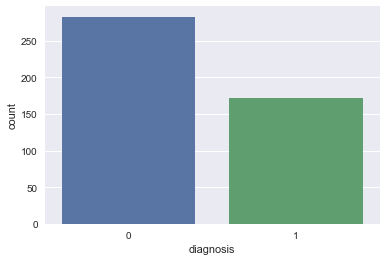

Fraction of tumors diagnosed malignant: 38%


In [7]:
sns.countplot(data['diagnosis'])
plt.show()

fracM = float(data['diagnosis'].mean()) * 100
print('Fraction of tumors diagnosed malignant: %.0f%%' % fracM)

So we'll quickly note that this dataset is slightly unbalanced, with more benign tumors than malignant. This is dangerous though because we want to avoid type II errors where a patient with a malignant tumor could be given a false negative. It is far more preferable to have type I errors (a false positive) where a healthy patient might need to undergo extra screening but no ones life is at risk.

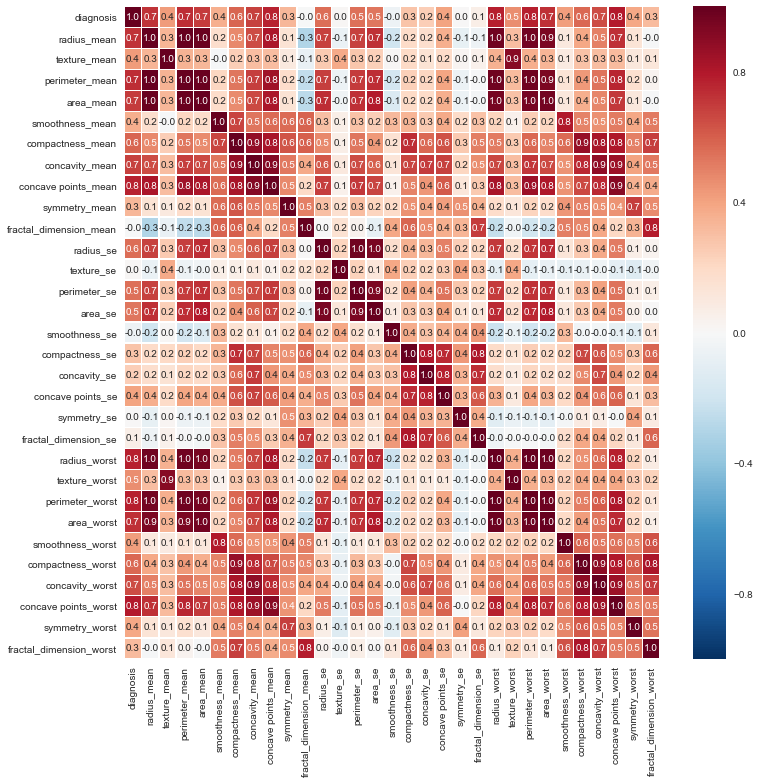

In [8]:
f, ax = plt.subplots(figsize=((12,12)))
sns.heatmap(data.corr(), annot=True, linewidth=.5, fmt='.1f', ax=ax)

So it seems that the diagnosis is highly correlated to several variables, but these variables are often highly correlated with one-another. The 'se' group seems to have the least predictive power while the 'worst' and 'average' groups have the most, but these subgroups are also highly correlated with one another. 

We could carefully go through these features in many ways but given there are so many features this would take some time. Instead, let's break this problem down and use PCA to create a few new features that contain the bulk of the information. 

## Feature engineering

Let's prep the dataset a little more, getting ready to feed it into a classifier

In [9]:
y, X = data_train.as_matrix()[:,0], data_train.as_matrix()[:,1:]
y_test, X_test = data_test.as_matrix()[:,0], data_test.as_matrix()[:,1:]

[  9.82188502e-01   1.57706144e-02   1.81563774e-03   1.23838522e-04
   8.89634427e-05   6.68176535e-06   4.16296913e-06   9.05893485e-07
   3.67513689e-07   2.16086902e-07   7.23967994e-08   1.67441296e-08
   7.44393306e-09   5.06254257e-09   3.31451632e-09   1.51129136e-09
   9.17839023e-10   5.28984585e-10   4.07994402e-10   3.69882174e-10
   1.77777172e-10   1.31146214e-10   9.05290936e-11   6.34438260e-11
   3.70671934e-11   2.92548561e-11   9.39082882e-12   6.52398631e-12
   4.81381159e-12   1.73031721e-12]


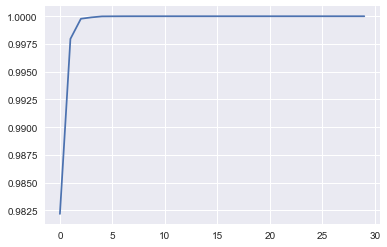

In [10]:
from sklearn.decomposition import PCA
pca = PCA().fit(X)
plt.plot(np.cumsum(pca.explained_variance_ratio_))
print(pca.explained_variance_ratio_)

Wow!!! We can get nearly 100% of the information in just 2 or 3 eigen-vectors!

## Training the XGBoost Model
So now we'll let the boosted tree algorithm of XGBoost work it's magic by training and then testing the accuracy on the test set.

In [11]:
model = xgb.XGBClassifier()
model.fit(X, y)

XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
       colsample_bytree=1, gamma=0, learning_rate=0.1, max_delta_step=0,
       max_depth=3, min_child_weight=1, missing=None, n_estimators=100,
       n_jobs=1, nthread=None, objective='binary:logistic', random_state=0,
       reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=None,
       silent=True, subsample=1)

Just to play with the XGBoost API a bit, let's save this trained model

In [12]:
pickle.dump(model, open("model.xgb", "wb"))

Again, just to play with the API, we'll load the XGBoost model that we just saved before applying predictions

In [13]:
#Load Model
model = pickle.load(open("model.xgb", "rb"))

# Make predictions
y_pred = model.predict(X_test)

# Calculate the accuracy
accuracy = accuracy_score(y_test, y_pred)*100.0
print('Test Accuracy: %.1f%%' % accuracy)

Test Accuracy: 96.5%


Not bad. Without any hyper-parameter optimization we can acheive ~96.5% accuracy!

## Error Analysis

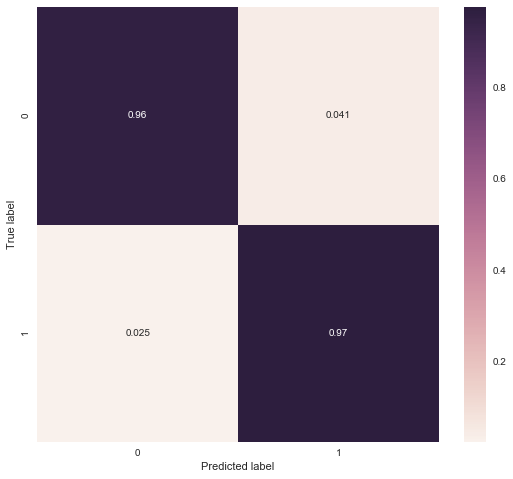

In [14]:
from sklearn.metrics import confusion_matrix
import seaborn as sn
plt.figure(figsize=(9,8))
cm = confusion_matrix(y_test, y_pred)
cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
sn.heatmap(cm, annot=True)

plt.ylabel('True label')
plt.xlabel('Predicted label')
plt.show();

So our final model is more likely to provide a false-positive than a false-negative, this is great! As discussed earlier in the notebook, it is far safer to subject a healthy patient to additional medical examination than to discharge a patient with a malignant tumor.   

## Further Improvements

To improve things further, we could: 
* add some cross-validation and try some hyper-parameter optimization to improve the model's performance 
* Rather than simply using accuracy as our figure of merit, it might be best to optimize our model for the smallest rate of false-negatives